In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [5]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

final_transformers = list()
final_transformers_lr = list()


for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    final_transformers_lr.append((cat_col, cat_transformer))

    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))
    
for cont_col in continuous_columns:
    cont_transformer_lr = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', MinMaxScaler()), 
            ])
    final_transformers_lr.append((cont_col, cont_transformer_lr))

In [10]:
feats = FeatureUnion(final_transformers)
feats_lr = FeatureUnion(final_transformers_lr)


feature_processing = Pipeline([('feats', feats)])
feature_processing_lr = Pipeline([('feats', feats_lr)])
feature_processing_lr

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
              

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

pipeline_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])
pipeline_lr = Pipeline([
    ('features',feats_lr),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [12]:
pipeline_rf.fit(X_train, y_train)
pipeline_gb.fit(X_train, y_train)
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [13]:
preds_rf = pipeline_rf.predict_proba(X_test)[:, 1]
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]

print(preds_rf[:10], preds_gb[:10], preds_lr[:10])

[0.37 0.26 0.16 0.02 0.02 0.67 0.04 0.12 0.15 0.75] [0.28502357 0.22926788 0.1982218  0.08930468 0.04798288 0.80662596
 0.03834531 0.05054472 0.31038377 0.73455865] [0.23147871 0.33342815 0.15457985 0.12706248 0.15737546 0.63172834
 0.06396248 0.08071225 0.35749076 0.75533412]


In [14]:
preds_lr[-1]

0.12525511236278153

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, preds_rf)

fscore_rf = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
# locate the index of the largest f score
ix = np.argmax(fscore_rf)
print('Best Threshold_rf=%f, F-Score_rf=%.3f, Precision_rf=%.3f, Recall_rf=%.3f' % (thresholds_rf[ix], 
                                                                        fscore_rf[ix],
                                                                        precision_rf[ix],
                                                                        recall_rf[ix]))

Best Threshold_rf=0.380000, F-Score_rf=0.641, Precision_rf=0.653, Recall_rf=0.629


Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


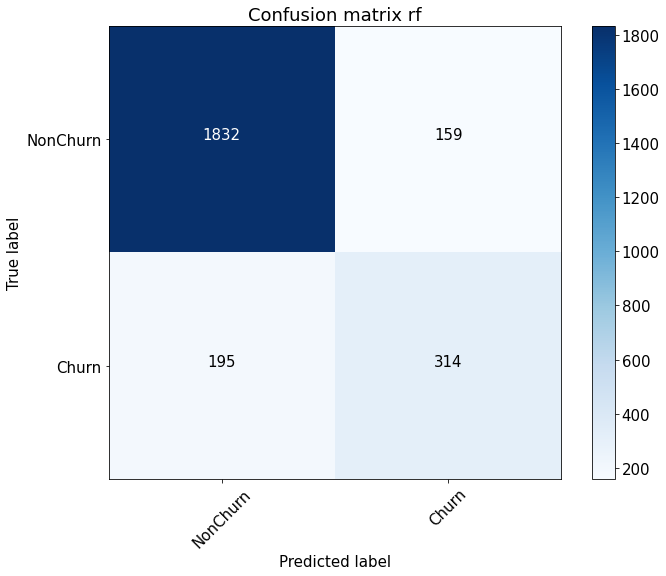

In [17]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_rf>thresholds_rf[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix rf')
plt.savefig("conf_matrix.png")
plt.show()

In [18]:
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, preds_gb)

fscore_gb = (2 * precision_gb* recall_gb) / (precision_gb + recall_gb)
# locate the index of the largest f score
ix = np.argmax(fscore_gb)
print('Best Threshold_gb=%f, F-Score_gb=%.3f, Precision_gb=%.3f, Recall_gb=%.3f' % (thresholds_gb[ix], 
                                                                        fscore_gb[ix],
                                                                        precision_gb[ix],
                                                                        recall_gb[ix]))

Best Threshold_gb=0.408508, F-Score_gb=0.646, Precision_gb=0.704, Recall_gb=0.597


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


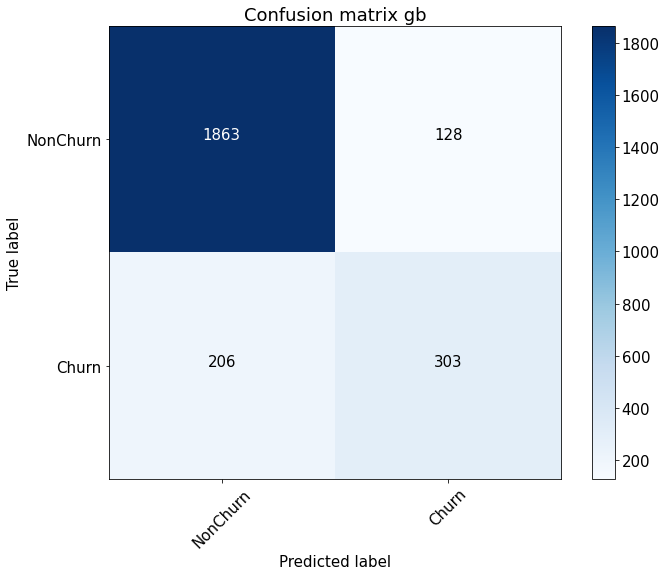

In [19]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_gb>thresholds_gb[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix gb')
plt.savefig("conf_matrix.png")
plt.show()

In [20]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, preds_lr)

fscore_lr = (2 * precision_lr * recall_lr) / (precision_lr + recall_lr)
# locate the index of the largest f score
ix = np.argmax(fscore_lr)
print('Best Threshold_lr=%f, F-Score_lr=%.3f, Precision_lr=%.3f, Recall_lr=%.3f' % (thresholds_lr[ix], 
                                                                        fscore_lr[ix],
                                                                        precision_lr[ix],
                                                                        recall_lr[ix]))

Best Threshold_lr=0.286079, F-Score_lr=0.509, Precision_lr=0.460, Recall_lr=0.570


Confusion matrix, without normalization
[[1650  341]
 [ 220  289]]


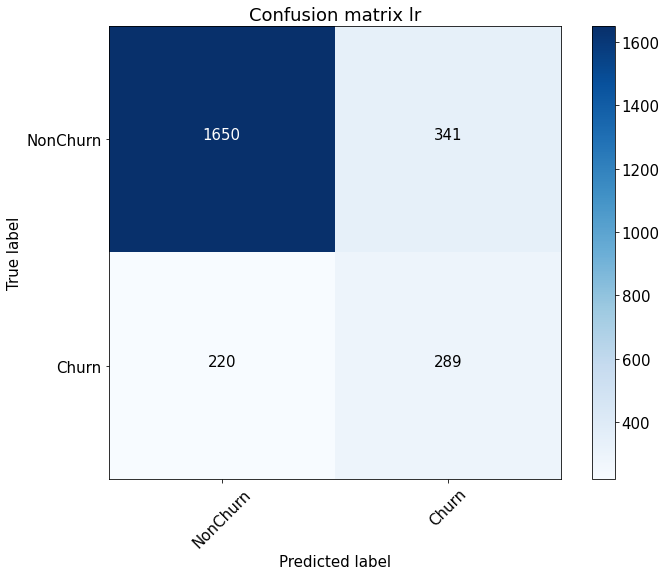

In [21]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_lr>thresholds_lr[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix lr')
plt.savefig("conf_matrix.png")
plt.show()

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Верно классифицированных - 1863 * 2 = 3726.

Потратим на привлечение - 1991 * 1 = 1991.

Итого прибыль составит - 3726 - 1991 = 1735

Судя по цифрам, модель является экономически целесообразной. 
Самая подходящая метрика, на мой взгляд, это precision так как чем он выше, тем больше денег мы заработаем, но учитывая то, что при низком recall, мы получим высокий precision, а в абсолютном значении это будет маленькое количество клиентов, денег мы заработаем мало. Поэтому, как всегда возвращаемся к балансу, но более внимательным взглядом на precision